# Part 1: Parsing the dataset

In [126]:
import os.path
import tarfile
from urllib.request import urlretrieve

from spyder.utils.snippets.lexer import tokenize

url = """http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz"""
if not os.path.exists(url.split("/")[-1]):
  urlretrieve(url, url.split("/")[-1])
  print("Downloaded", url)
  with tarfile.open('review_polarity.tar.gz', 'r:gz') as tar:
    tar.extractall()
  print("Extracted archive")

In [127]:
import os
import numpy as np

In [128]:
# takes a path and returns a list with the content of all files at that path
def get_reviews(path):
    filenames_lst = os.listdir(path)
    reviews_lst = []
    for i in range(len(filenames_lst)):
        path_full = os.path.join(path, filenames_lst[i])
        with open(path_full, 'r') as f:
            reviews_lst.append(f.read())
    return reviews_lst

folder_name = 'txt_sentoken'
neg_path = os.path.join(folder_name, 'neg')
pos_path = os.path.join(folder_name, 'pos')
neg_reviews = get_reviews(neg_path)
pos_reviews = get_reviews(pos_path)

In [129]:
# check that both lists are the correct length
assert len(neg_reviews) == 1000
assert len(neg_reviews) == len(pos_reviews)

In [130]:
# create the full list
X_full = neg_reviews + pos_reviews

# create the training list and testing list
split_point = int(len(neg_reviews)*0.8)
X_train = neg_reviews[:split_point] + pos_reviews[:split_point]
X_test = neg_reviews[split_point:] + pos_reviews[split_point:]

# create the corresponding outcome lists
y_full = [-1 for i in range(int(len(X_full)/2))] + [1 for i in range(int(len(X_full)/2))]
y_train = [-1 for i in range(split_point)] + [1 for i in range(split_point)]
y_test = [-1 for i in range(int(len(X_test)/2))] + [1 for i in range(int(len(X_test)/2))]

In [131]:
# check the train and test lists are the correct lengths
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

# check the train and test lists are the correct types / values
assert np.all([isinstance(x, str) for x in X_train])
assert np.all([isinstance(x, str) for x in X_test])
assert len(np.unique(y_train))==2
assert min(y_train) == -1
assert max(y_train) == 1
assert len(np.unique(y_test))==2
assert min(y_test) == -1
assert max(y_test) == 1

# Part 2: Feature extraction

In [132]:
class Vectorizer:

    # the instance will only store the vocabulary once the make_vocabulary method has been used
    def __init__(self):
        self.vocabulary = None

    @staticmethod
    def tokenize(txt):
        return [token for line in txt.split("\n") for token in line.split()]

    # takes a list of texts and creates the vocabulary (list of unique tokens)
    def make_vocabulary(self, data):
        """ not efficient: many tokens appear in many reviews so the 2nd for loop will iterate over the same token many times """
        vocab = []
        for review in data:
            for token in self.tokenize(review):
                if token not in vocab:
                    vocab.append(token)
        self.vocabulary = vocab

    # takes a list of texts and returns its corresponding bag-of-words vector, according to the vocabulary
    def transform_to_bow(self, data_list):
        matrix_size = (len(data_list), len(self.vocabulary))
        X = np.zeros(matrix_size)
        for i, txt in enumerate(data_list):
            for token in self.tokenize(txt):
                X[i, self.vocabulary.index(token)] = 1
        return X

In [133]:
vectorizer = Vectorizer()

# create the vocabulary
""" both train and test sets are included in the vocabulary, to avoid unseen words later """
vectorizer.make_vocabulary(X_full)

# turns the lists into bag_of_words matrices
X_train = vectorizer.transform_to_bow(X_train)
X_test = vectorizer.transform_to_bow(X_test)

# transform the y lists into np arrays for an easier time down the line
y_train = np.array(y_train)
y_test = np.array(y_test)

In [134]:
# get the vocabulary
ordered_vocabulary = vectorizer.vocabulary

In [135]:
assert X_test.shape[1] == X_train.shape[1]

# Part 3: Learning framework

This was horrible. I don't think neither my understanding of the instructions nor the code are correct yet.

Handling the shapes of the vectors/matrices was very difficult to understand, I have spent more time testing numpy formulas in the python console than working on the notebook, and in the end I had to ask GPT for help, else the code would not run.

It also took a long time for me to realize the hinge loss uses the score and not the prediction. This still doesn't make sense to me. Why compare the expected value (a 1 or -1) to a random weird number that does not mean much?!

In [176]:
class Classifier:
    def __init__(self, vocabulary, n_max_iter=500, regularizer_dampening=0.001, learning_rate=0.1):
        self.param_vector = np.random.normal(size=len(vocabulary)+1)
        self.n_max_iter = n_max_iter
        self.lambduh = regularizer_dampening
        self.gamma = learning_rate
        self.loss = []

    def _score(self, X):
        z = np.matmul(X, self.param_vector) # internet says matmul is more efficient than dot for matrices
        return z

    def _loss(self, X, y):
        """ - Instructions mention both L1 and l2 regularization, I did l1, hopefully that's ok
        - Why do loss sum when we could do loss average ?
        - Also, the intercept (first element of model.param_vector) gets regularized, maybe that's a problem? """
        z = self._score(X) # gets the score, not the prediction
        loss_vector = np.maximum(0,1-np.multiply(y,z)) # hinge loss
        regularization = self.lambduh * np.sum(np.absolute(self.param_vector)) # l1 regularization
        loss = regularization + np.sum(loss_vector) # loss sum instead of average?
        self.loss.append(loss)
        return loss

    def _gradient(self, X, y):
        v1 = np.multiply(y, self._score(X))
        index = v1 < 1 # condition
        v = np.zeros(X.shape)
        v[index] = -y[index].reshape((-1,1)) * X[index] # reshape so multiplication works
        return self.lambduh * np.sign(self.param_vector) + np.sum(v, axis=0) # sum on row axis, not colum

    def fit(self, X, y):
        """ the early exit condition does not make sense to me, so I did this instead:
        loss_best > loss_curr > loss_best-0.1 """ # using 0.001 is too 'severe' with the loss sum
        X = np.insert(X, 0, 1, 1) # add the pseudo-input
        i = 0
        counter = 0
        while i < self.n_max_iter:
            loss_curr = self._loss(X, y)
            self.param_vector = self.param_vector - self.gamma * self._gradient(X, y)

            # exit early if the loss hasn't decreased by more than 0.1 in 5 consecutive iterations
            if len(self.loss) > 1:
                loss_best = min(self.loss[:-1])
                if loss_best > loss_curr and loss_curr > loss_best - 0.1:
                    counter += 1
                else:
                    counter = 0
            if counter == 5:
                break
            i += 1
        return self

    def predict(self, X):
        """ np.sign can return 0, maybe that's a problem? """
        X = np.insert(X, 0, 1, 1) # add the pseudo input
        z = self._score(X)
        y_hat = np.sign(z)
        return y_hat

In [177]:
model = Classifier(ordered_vocabulary)
model.fit(X_train, y_train) # training

In [178]:
import matplotlib.pyplot as plt

def show_plot(data, x_label, y_label, size=(20,10)):
    plt.figure(figsize=size)
    plt.plot(data)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

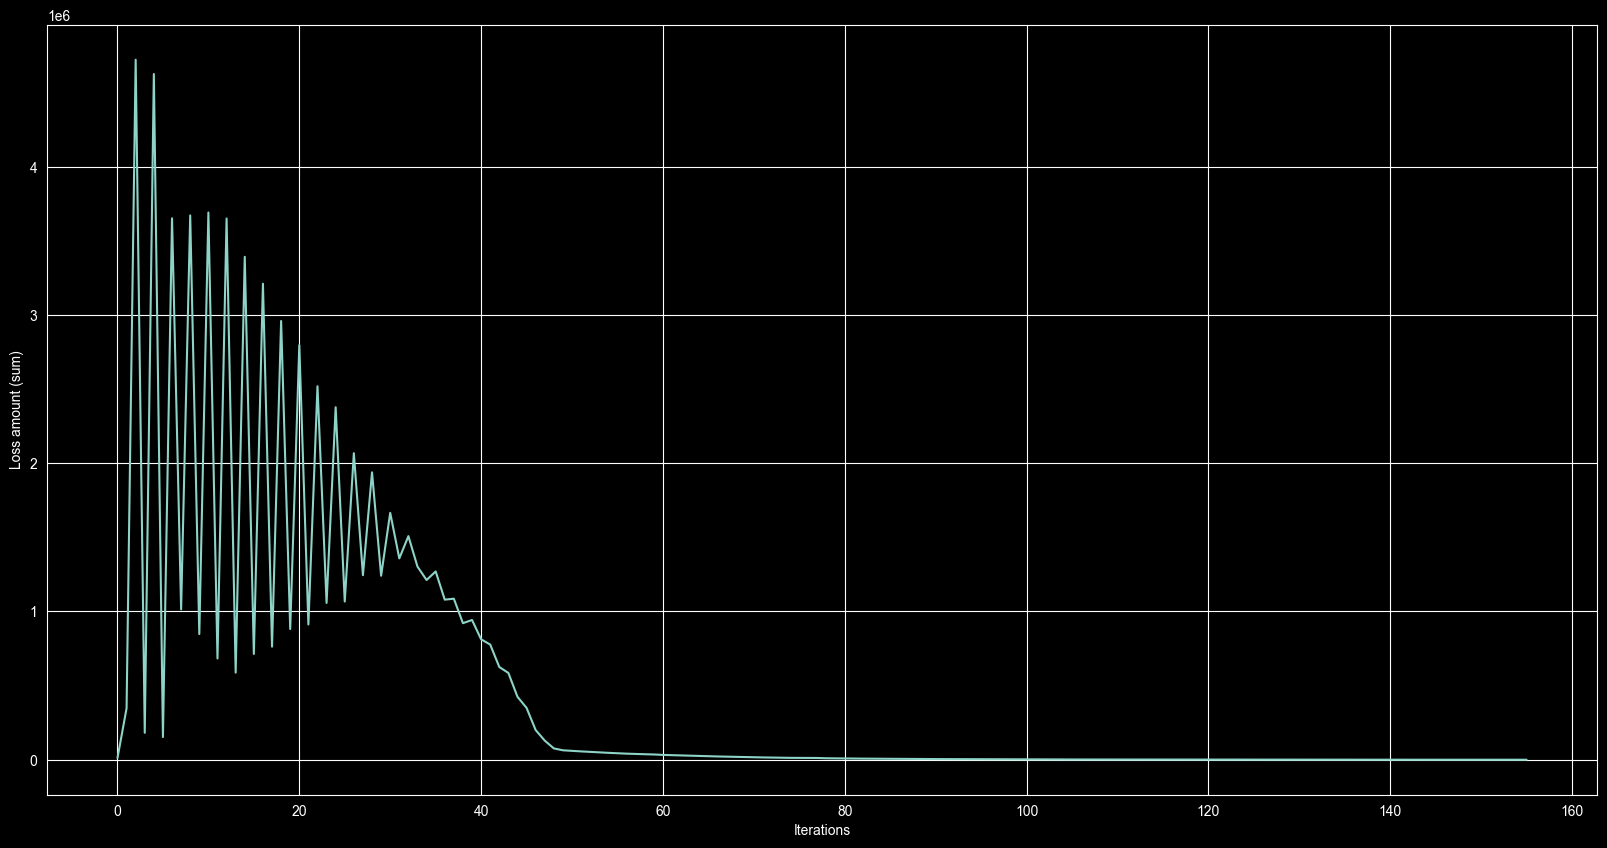

In [179]:
show_plot(model.loss, "Iterations", "Loss amount (sum)")

Just wanted to see what the loss looked like, I don't understand why it is so squiggly at the start.

Since the param_vector is initialized with random numbers, it changes everytime I recreate the model, but it is always super squiggly for the 40 first iterations.

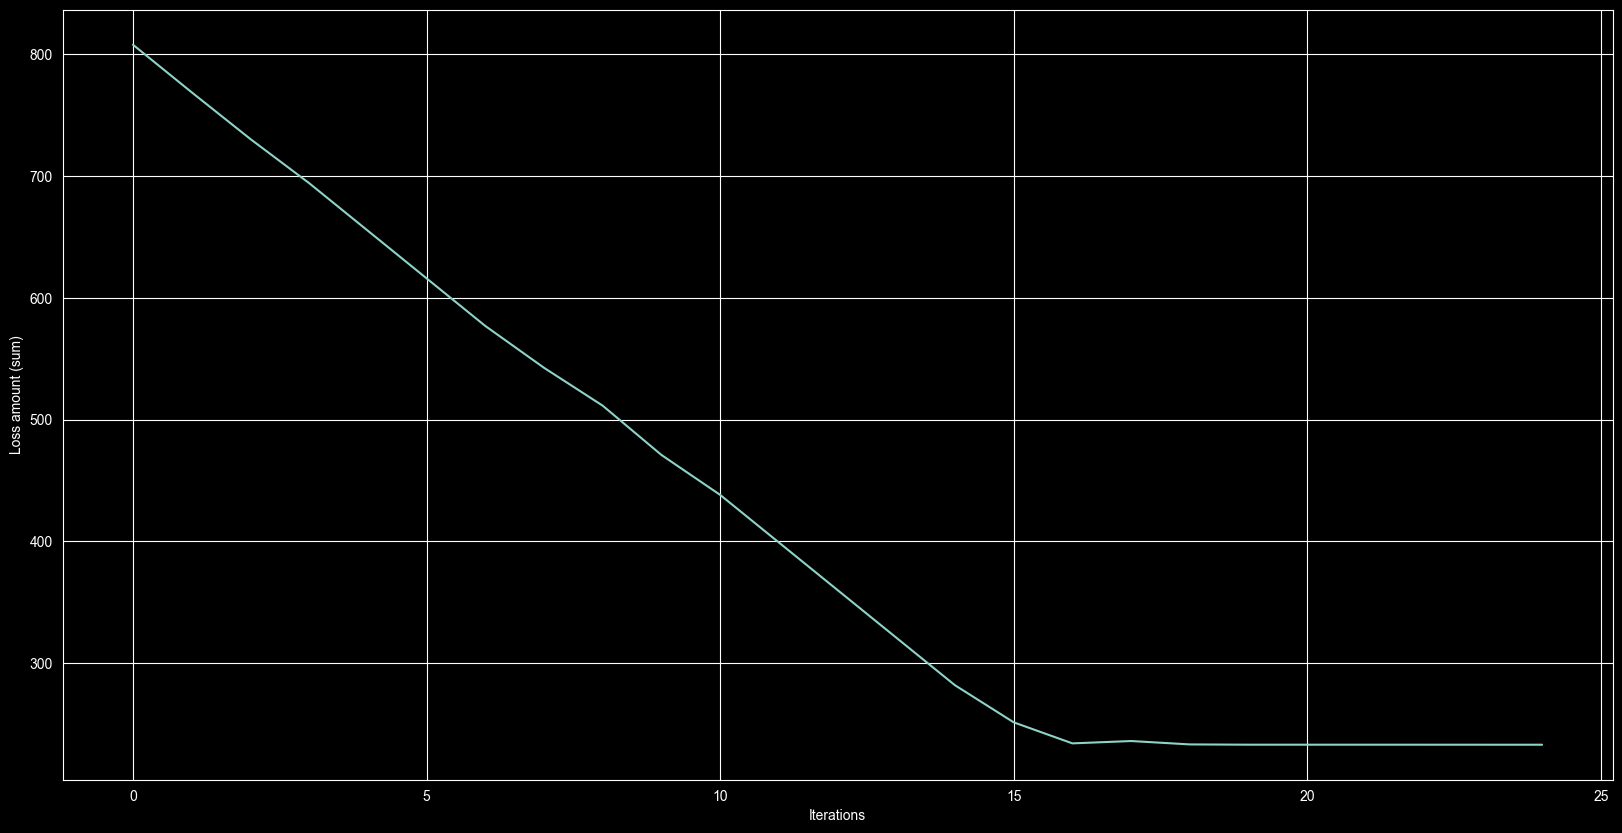

In [180]:
show_plot(model.loss[-25:], "Iterations", "Loss amount (sum)")

It seems the best loss (sum) I can get is around 250

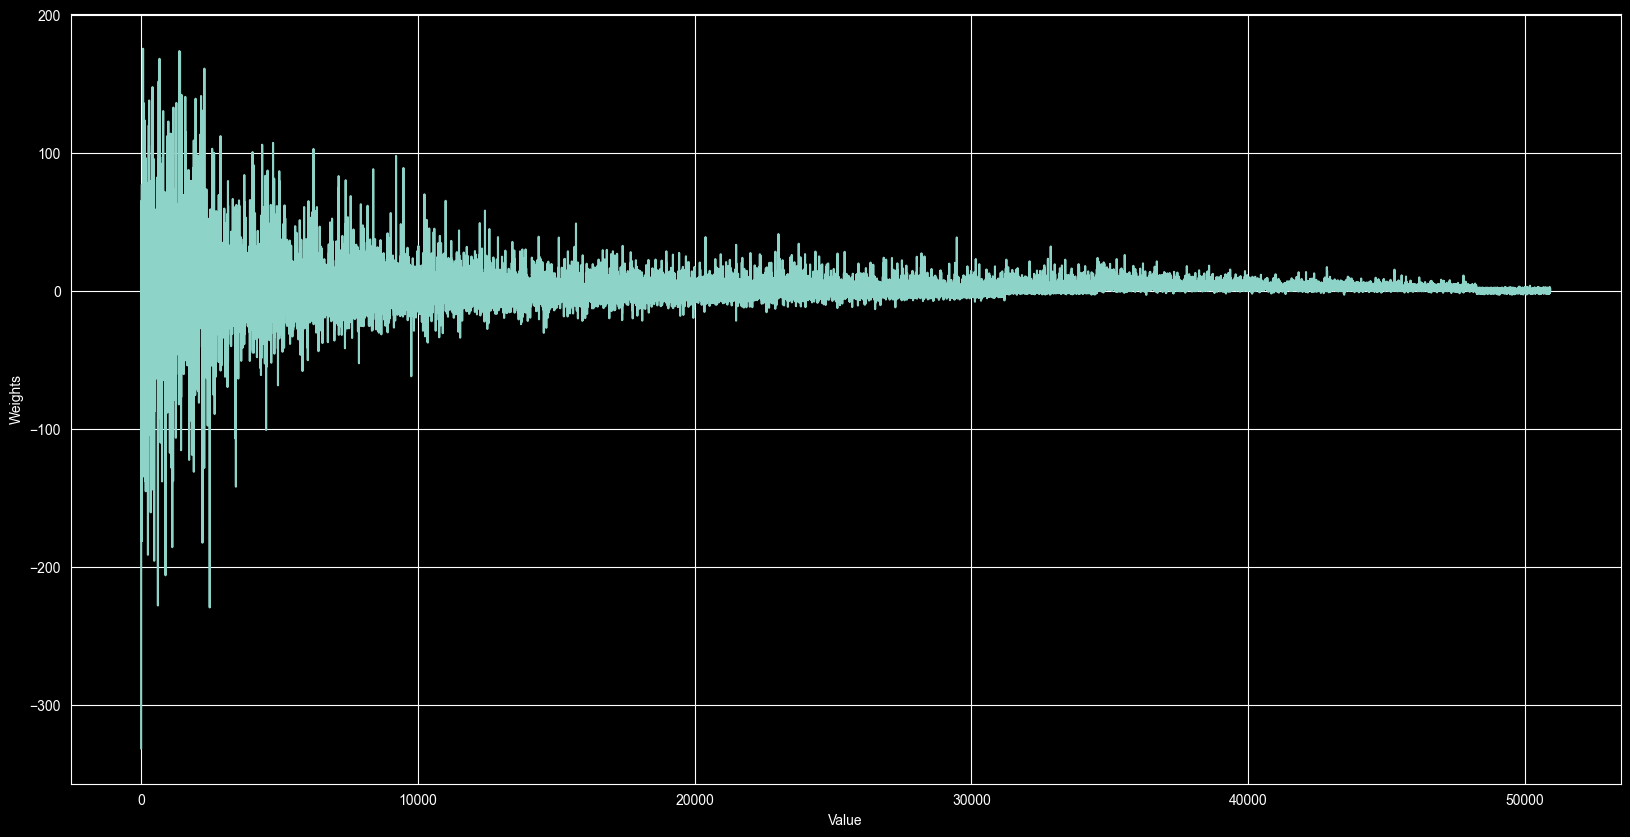

In [181]:
show_plot(model.param_vector[1:], "Value", "Weights")

I feel like it's not normal that the first ~1000 words influence the predictions a LOT more than the rest. I guess I did something wrong somewhere, most likely in the Vectorizer class, or the regularisation part of the Classifier class.

In [182]:
assert len(model.param_vector[1:]) == len(ordered_vocabulary)

In [183]:
idx = np.argsort(np.abs(model.param_vector[1:]))

print("                Word   Weight  Occurences")
for i in idx[-20:]:   # Pick those with highest 'voting' values
    print("%20s   %.3f\t%i " % (ordered_vocabulary[i], model.param_vector[i+1], np.sum([ordered_vocabulary[i] in d for d in X_train])))

                Word   Weight  Occurences
               least   -144.078	0 
               awful   -145.288	0 
                life   147.595	0 
        performances   151.741	0 
               looks   -160.600	0 
           hilarious   160.955	0 
              stupid   -164.419	0 
                very   168.105	0 
                both   172.616	0 
                best   173.711	0 
                also   175.385	0 
                   ?   -181.431	0 
       unfortunately   -182.563	0 
            supposed   -185.787	0 
             nothing   -191.321	0 
              boring   -195.652	0 
              script   -206.165	0 
                plot   -228.039	0 
               worst   -229.458	0 
                 bad   -331.837	0 


Why the f*ck are all occurrences at 0 do you ask? I don't know. I think it's because of the fact I included both train and test sets in the vocabulary? I hate myself, and this assignment.

# Part 4: Exploring hyperparameters

In [184]:
# Define the parameters
n_samples = 10
best_hparam = None

I just copy-pasted the code from the instructions and changed the variables to match my code

In [185]:
print("Learning rate:\tReg.dampening:\tTraining set accuracy:")
for a, b in zip(np.random.choice(np.logspace(-4, 3, num=1000), n_samples), np.random.choice(np.logspace(-4, 3, num=1000), n_samples)):

  # Set up the classifier
  model = Classifier(ordered_vocabulary, regularizer_dampening=a, learning_rate=b)

  # Train the classifier
  model.fit(X_train, y_train)

  # Calculate the training accuracy

  train_accuracy = np.sum(model.predict(X_train) == y_train) / len(y_train)

  # Store the hyperparameters if they are better than what we have found before
  if best_hparam is None or best_hparam[2] < train_accuracy:
    best_hparam = (a, b, train_accuracy)
  print("%.3f\t\t%.3f\t\t%.1f%%" % (a, b, 100 * train_accuracy))

best_a = best_hparam[0]
best_b = best_hparam[1]
print("Best parameters: %.5f, %.5f" % (best_a, best_b))

Learning rate:	Reg.dampening:	Training set accuracy:
0.335		0.001		100.0%
0.058		0.002		100.0%
3.308		823.979		95.6%
0.001		0.034		100.0%
0.299		1.653		100.0%
0.294		0.010		100.0%
0.003		0.001		100.0%
2.357		0.068		97.6%
0.165		4.422		99.8%
102.804		2.006		50.0%
Best parameters: 0.33460, 0.00069


Why is the accuracy so high??? Does that mean my model is overfitted?

The early exit condition was for a loss decrease of less than 0.1 for 5 five consecutive iterations. Since we do loss sum, maybe it should be bigger? 10 instead of 0.1?

Also, the param_vector starts with random values, so it's different for pair of hyperparameters testes. Is that a problem? I don't think that is relevant since the param_vector is changed as the model is trained anyway, ... but maybe?

In [186]:
# Set up the classifier
model = Classifier(ordered_vocabulary, regularizer_dampening=best_a, learning_rate=best_b)

# Train on all the non-test data
model.fit(X_train, y_train)

# Run prediction on the test set
test_accuracy = np.sum(model.predict(X_test)==y_test)/len(y_test)

print("Test set accuracy %.1f%%" % (100*test_accuracy))

Test set accuracy 73.0%


Alright, I know, I cheated, I ran the model on the test set just to check what accuracy I'd get, even though the model needs 'tweaking' (ie. complete rebuilding), sorry, sorry!

But, since I got 100% on the train set but 73% on the test set, I am correct in thinking the model was overfitted to the train set, ... right?

I really need to move on if I want to try the VG part, which I definitely do, and I would really appreciate feedback on what I've done so far because I know something is clearly wrong somewhere, but I am really not sure about anything and might make it worse by trying to correct it all without any help.

So I'll leave it like this for now and start reading up on the VG stuff. I hope that's ok, if not, my bad.

# Report

'A description of the implementation work': ... so, ... a summary of the instructions??

# Part: VG

In [ ]:
class Vectorizer_but_better(Vectorizer):

    def tf_idf(self):
        pass

    # takes a list of texts and returns its corresponding bag-of-words vector, according to the vocabulary
    def transform_to_bow(self, data_list):
        matrix_size = (len(data_list), len(self.vocabulary))
        X = np.zeros(matrix_size)
        for i, txt in enumerate(data_list):
            for token in self.tokenize(txt):
                X[i, self.vocabulary.index(token)] = 1
        return X

In [ ]:
class SGDClassifier(Classifier):

    def _gradient(self, X, y):
        v1 = np.multiply(y, self._score(X))
        index = v1 < 1 # condition
        v = np.zeros(X.shape)
        v[index] = -y[index].reshape((-1,1)) * X[index] # reshape so multiplication works
        return self.lambduh * np.sign(self.param_vector) + np.sum(v, axis=0) # sum on row axis, not colum

# PLEASE FAIL ME, I WANT THE VG GRADE BUT DID NOT FINISH IN TIME (obviously)